In [68]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from d2l import torch as d2l
from torchvision.transforms import transforms
import torch.utils.data as Data

In [69]:
def corr2d(X, K):  #@save
    """计算二维互相关运算"""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [70]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

In [71]:
#输入图像
x = torch.zeros(6,6)
for i in range(6):
    x[i,i]=1
#卷积核
k = torch.tensor([[1.0,-1.0]])

In [72]:
y = corr2d(x.t(),k.t())
y

tensor([[ 1., -1.,  0.,  0.,  0.,  0.],
        [ 0.,  1., -1.,  0.,  0.,  0.],
        [ 0.,  0.,  1., -1.,  0.,  0.],
        [ 0.,  0.,  0.,  1., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  1., -1.]])

In [73]:
y = corr2d(x,k.t())
y

tensor([[ 1., -1.,  0.,  0.,  0.,  0.],
        [ 0.,  1., -1.,  0.,  0.,  0.],
        [ 0.,  0.,  1., -1.,  0.,  0.],
        [ 0.,  0.,  0.,  1., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  1., -1.]])

In [74]:
#leNet网络
lenet = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=3, padding=2),nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5,padding=0),nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=1),
    nn.Flatten(),
    nn.Linear(16 * 10 * 10, 120),nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84),nn.Sigmoid(),
    nn.Linear(84, 10))

In [75]:
#leNet网络
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

In [76]:
print(lenet)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Sigmoid()
  (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Sigmoid()
  (7): AvgPool2d(kernel_size=2, stride=1, padding=0)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=1600, out_features=120, bias=True)
  (10): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Sigmoid()
  (12): Linear(in_features=120, out_features=84, bias=True)
  (13): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Sigmoid()
  (15): Linear(in_features=84, out_features=10, bias=True)
)


In [77]:
#下载数据
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [78]:
# for i,(x,y) in enumerate(train_iter):
#     print(x.shape)

In [79]:
#测试精度
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [80]:
#训练
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    f = open('output','a')
    f.write(str(net)+'\n')
    f.write(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}'+'\n')
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.226, train acc 0.917, test acc 0.877
2411.9 examples/sec on cpu


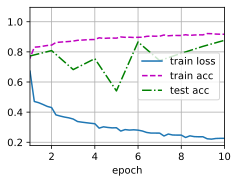

In [81]:
lr, num_epochs = 0.9, 10
train_ch6(lenet, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
#train_ch6(lenet, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [82]:
from torchvision.datasets import FashionMNIST


# 处理训练集数据
def train_data_process():
    # 加载FashionMNIST数据集
    train_data = FashionMNIST(root="data",  # 数据路径
                              train=True,  # 只使用训练数据集
                              transform=transforms.Compose([transforms.ToTensor()]),
                              # AlexNet的输入数据大小为224*224，因此这里将FashionMNIST数据集的尺寸从28扩展到224
                              # 把PIL.Image或者numpy.array数据类型转变为torch.FloatTensor类型
                              download=True,  # 若本身没有下载相应的数据集，则选择True
                              )
    train_loader = Data.DataLoader(dataset=train_data,  # 传入的数据集
                                   batch_size=64,  # 每个Batch中含有的样本数量
                                   shuffle=True,  # 不对数据集重新排序
                                   num_workers=0,  # 加载数据所开启的进程数量
                                   )
    print("The number of batch in train_loader:", len(train_loader))  # 一共有938个batch，每个batch含有64个训练样本

    # 获得一个Batch的数据
    for step, (b_x, b_y) in enumerate(train_loader):
        if step > 0:
            break
    batch_x = b_x.squeeze().numpy()  # 将四维张量移除第1维，并转换成Numpy数组
    batch_y = b_y.numpy()  # 将张量转换成Numpy数组
    class_label = train_data.classes  # 训练集的标签
    class_label[0] = "T-shirt"
    print("The size of batch in train data:", batch_x.shape)  # 每个mini-batch的维度是64*224*224
    #初始化一个列表
    a = []
    # 可视化一个Batch的图像
    plt.figure(figsize=(12, 5))
    for ii in np.arange(2):
        plt.subplot(1, 2, ii + 1)
        plt.imshow(batch_x[ii, :, :], cmap=plt.cm.gray)
        plt.title(class_label[batch_y[ii]], size=9)
        plt.axis("off")
        plt.subplots_adjust(wspace=0.05)
    plt.show()
    x = batch_x[0,:,:]
    y = batch_x[1,:,:]
    x_label = batch_y[0]
    y_label = batch_y[1]
    #print(x.shape)

    return x,x_label,y,y_label

The number of batch in train_loader: 938
The size of batch in train data: (64, 28, 28)


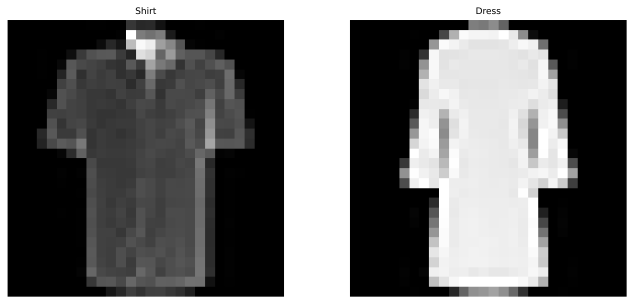

OrderedDict([('weight', tensor([[[[-0.0079,  0.0310, -0.1031,  0.1963, -0.0851],
          [-0.1136, -0.1099,  0.0211, -0.1017, -0.1233],
          [-0.1676,  0.1264, -0.1027, -0.1043, -0.0887],
          [ 0.0260, -0.0287, -0.1068,  0.0657,  0.1454],
          [-0.1494, -0.0374, -0.0057,  0.1886,  0.0477]]],


        [[[-0.1573, -0.0012, -0.1771, -0.0723, -0.1769],
          [ 0.1680, -0.0793, -0.1752,  0.1373, -0.1412],
          [-0.1022,  0.0767,  0.1492, -0.0595, -0.1256],
          [-0.0485,  0.0516,  0.1156, -0.0536, -0.1977],
          [ 0.0535,  0.1767,  0.0068,  0.0547, -0.0160]]],


        [[[ 0.0927,  0.0235,  0.0615,  0.0742, -0.0961],
          [-0.0987,  0.0897, -0.0607, -0.0983,  0.1975],
          [ 0.1070,  0.0524, -0.1498, -0.1679, -0.0073],
          [-0.1224, -0.0006,  0.1094, -0.0675, -0.1637],
          [-0.0614, -0.0258, -0.0898, -0.1985,  0.0156]]],


        [[[-0.1875, -0.1196,  0.0724,  0.1827,  0.1473],
          [ 0.1413,  0.0492,  0.0764, -0.0057, -0.12

In [83]:
p1,p1_label,p2,p2_label = train_data_process()
p1 = torch.tensor(p1).unsqueeze(0).unsqueeze(0)
p2 = torch.tensor(p2).unsqueeze(0).unsqueeze(0)
# for i, (X, y) in enumerate(train_iter):
#     y=i+1
c = net(p1)
print(net[0].state_dict(),'\n')
print(c,'\n')
print(p1_label,'\n')
c2 = net(p2)
print(net[1].state_dict(),"\n")
print(c2,'\n')
print(p2_label)


In [84]:
for i, (X, y) in enumerate(train_iter):
    y=i+1
print(X.shape)

torch.Size([96, 1, 28, 28])
